Imports

In [1]:
import json
from pycsp3 import *
import matplotlib.pyplot as plt
from matplotlib import patheffects

In [2]:
machines_array = []
tasks_array = []
n_ressources=0
ntasks=0
nMachines=0

In [3]:
def link_values_pairwise(arrays):
    result = {}
    for j in range(1, len(arrays)):
        array2 = arrays[j]
        for k in range(len(array2)):
            val2=array2[k]
            if val2 is not None:
              result[val2] = []
              for i in range(j):
                array1 = arrays[i]
                val1=array1[k]
                if val1 is not None :
                  result[val2].append(val1)
    return result

In [4]:
def draw_schedule(activities, end, width=15, height=8):
    n_machines=len(activities)
    fig, ax = plt.subplots(figsize=(width, height)) 
    ax.set_xlim(0, end+1)
    ax.set_ylim(0, n_machines + 1)
    for i, activity_line in enumerate(activities, start=1):
        for activity in activity_line:
            start_time = activity['start_time']
            duration = activity['duration']
            end_time = start_time + duration
            ax.plot([start_time, end_time], [i, i], linewidth=20, solid_capstyle='butt')
            text_x = (start_time + end_time) / 2
            text_y = i
            mytxt = ax.text(text_x, text_y, activity['name'], ha='center', va='center', color='white', fontsize=12)
            mytxt.set_path_effects([patheffects.withStroke(linewidth=3, foreground='black')])

    ax.set_yticks(range(1, n_machines + 1))
    ax.set_yticklabels([f'Machine {i}' for i in range(1, n_machines+1)])
    ax.set_xlabel('Time')
    ax.set_title("Tasks execution took "+str(end)+" units of time")
    plt.grid(True)
    plt.show()

In [5]:
def allDifferentMachines(tasks_indexs, new_task, previous_min=nMachines):
    tasks_indexs.add(new_task)
    if len(tasks_indexs)==1:
        return True, previous_min
    
    mymin = min(previous_min,len(tasks_array[new_task][1]))
    if mymin>=len(tasks_indexs):
        return True, mymin
    clear()
    tasks_machines = []
    for index in tasks_indexs:
        tasks_machines.append(Var(dom=set(tasks_array[index][1]), id='task_machine'+str(index)))
    satisfy(
        AllDifferent(tasks_machines)#using pycsp to check if all task can be executed on different valid machines
    )
    result = solve()
    if result != SAT:
        tasks_indexs.remove(new_task)
        return False, previous_min
    return True, mymin

In [45]:
def orderGenerator():
    greedy_order = sorted(range(ntasks), key=lambda i: (-tasks_array[i][0], -len(tasks_array[i][2]), -len(tasks_array[i][1])))
    #greedy_order = sorted(range(ntasks), key=lambda i: (-tasks_array[i][0], -len(tasks_array[i][1]), len(tasks_array[i][2])))#order by higher length,
    #greedy_order = sorted(range(ntasks), key=lambda i: (-len(tasks_array[i][2]), -tasks_array[i][0], -len(tasks_array[i][1])))
                                                                #then higher number of available machines, then lower number of needed ressources
    my_batches=[]
    old_tabu_ressources = set([i for i in range(n_ressources)])
    updated_machines_number=nMachines
    ressources_users=[] # [ressource number]
    non_ressources_users=[]
    while True:#go greedy when you're done assigning ressource I guess ?
        tabu_ressources = set()
        current_batch = set()
        batch_min=nMachines
        #machines_usage=[0 for _ in range(nMachines)]
        updated_ressources_number=len(old_tabu_ressources)
        ressources_users.append([None for _ in range(n_ressources)])
        iteration = len(ressources_users)-1
        for tasks_index in greedy_order:
            if len(tabu_ressources)==updated_ressources_number:
                break
            if len(tasks_array[tasks_index][2])>0:
                if(tabu_ressources.isdisjoint(tasks_array[tasks_index][2])):
                    tmp_bool, batch_min= allDifferentMachines(current_batch, tasks_index, batch_min)
                    if tmp_bool:
                        for ressource in tasks_array[tasks_index][2]:
                            tabu_ressources.add(ressource)
                            ressources_users[iteration][ressource]=tasks_index
                            
        tmpMax= max()
        #if len(tabu_ressources)==0:
        if len(greedy_order)==0:
            break
        old_tabu_ressources=tabu_ressources

        greedy_order = [x for x in greedy_order if x not in current_batch]
        non_ressources_users.append([])
        
        for tasks_index in greedy_order:
            if len(current_batch)==updated_machines_number:# gain time, but maybe condition is kinda fucked up because of some task being denied entry to the batch due to ressources incompatibilities ?
                    break
            if(tabu_ressources.isdisjoint(tasks_array[tasks_index][2])):
                tmp_bool, batch_min= allDifferentMachines(current_batch, tasks_index, batch_min)
                if tmp_bool:
                    non_ressources_users[iteration].append(tasks_index)
                
        greedy_order = [x for x in greedy_order if x not in current_batch]

        updated_machines_number=len(current_batch)
        #print(f"{current_batch}|{greedy_order}")
        my_batches.append(current_batch)
    if len(greedy_order)>0:
        my_batches.append(greedy_order)
    return my_batches, ressources_users, non_ressources_users


In [46]:
def read_input(input_file):
    global n_ressources
    global machines_array
    global tasks_array
    machines_array = set()
    tasks_array = []

    if input_file.endswith('.pl'):
        with open(input_file, 'r') as file:
            for line in file:
                if line.startswith('test('):
                    #test( 't8', 347, ['m10','m4'], [], 'fam1', 1 ).
                    big_parts = line.split('[')
                    duration = int(big_parts[0].split(',')[1].strip())
                    
                    machines = big_parts[1].replace(' ','').replace(']', '').replace("'", '').replace('m', '').split(',')
                    machines = [(int(machine)-1) for machine in machines if machine.isdigit()]
                    
                    resources = big_parts[2].split(']')[0].replace(' ','').replace('[', '').replace("'", '').replace('r', '').split(',')
                    resources = [(int(resource)-1) for resource in resources if len(resource)>0]
                    
                    if len(machines)>0:
                        tasks_array.append([duration, machines, resources])
                    else:
                        tasks_array.append([duration, machines_array, resources])

                elif line.startswith('% Number of machines'):
                    machines_array = sorted(range (int(line.split(':')[1].strip())))
                elif line.startswith('% Number of resources'):
                    n_ressources = int(line.split(':')[1].strip())

    elif input_file.endswith('.json'):
        file = open(input_file)
        file_data = json.load(file)
        n_ressources=file_data['nResources']
        machines_array = sorted(range (int(file_data['nMachines'])))
        for task in file_data['tests']:
            if len(task['machines'])>0:
                tasks_array.append([int(task['duration']), task['machines'], task['resources']])
            else:
                tasks_array.append([int(task['duration']), machines_array, task['resources']])
    else:
        print("error : unknown format")

In [47]:
test_files=['./t10-example.json', './t20m10r3-1.json', './t40m10r3-2.json']
read_input(test_files[2])
#test_files=[]
#for filename in os.listdir("."):
#    if filename.endswith(".log"):
#        test_files.append(""+filename)
#read_input("./tests_folder/t500m50r5-5.pl")
ntasks=len(tasks_array)
nMachines=len(machines_array)
all_batches, ressources_users, non_ressources_users = orderGenerator()
ressource_links_map = link_values_pairwise(ressources_users)
print(f"all batches {len(all_batches)} {all_batches}")
print(ressources_users)
print(ressource_links_map )

all batches 8 [{1, 3, 37, 20, 23}, {33, 2, 5, 28, 29}, {32, 0, 9, 15, 19}, {36, 17, 22, 27, 30}, {4, 10, 12, 21, 25}, {34, 39, 16, 24, 26}, {35, 7, 8, 11, 13}, {6, 38, 14, 18, 31}]
[[23, 20, 1], [None, 28, 29], [32, 32, 32], [None, 36, 36], [None, None, 25], [None, None, None], [None, None, None], [None, None, None], [None, None, None]]
{28: [20], 29: [1], 32: [1, 29], 36: [1, 29, 32], 25: [1, 29, 32, 36]}


In [48]:
clear()
tasks_machines = [None for _ in range(ntasks)]
tasks_starts= [None for _ in range(ntasks)]
worst=1
all_batches_min = all_batches_max = 0
for batch in all_batches:
    current_min = current_max = 0
    tmp = []
    for index in batch:
        current_min = min(current_min, tasks_array[index][0])
        current_max = max(current_max, tasks_array[index][0])
        tasks_machines[index]=Var(dom=set(tasks_array[index][1]), id='task_machine'+str(index))
        tasks_starts[index]=Var(dom=range(all_batches_min,all_batches_max+1), id='start_task'+str(index))
        tmp.append(tasks_machines[index])
    satisfy(
        AllDifferent(tmp)
    )
    all_batches_min+=current_min
    all_batches_max+=current_max
score = Var(dom=range(all_batches_min, all_batches_max+1))

In [49]:
satisfy(
    [tasks_starts[i]==0 for i in all_batches[0]],

    [ If(tasks_machines[current_index]==tasks_machines[previous_index],
         Then=tasks_starts[current_index]==tasks_starts[previous_index]+tasks_array[previous_index][0])
     for current_batch in range(1, len(all_batches))
     for current_index in non_ressources_users[current_batch]
     for previous_index in all_batches[current_batch-1]],

    score==Maximum((tasks_starts[i]+tasks_array[i][0])
                for i in range(ntasks))
)
print("")#just to avoid printing conditions

In [50]:
for ressource_users_batch in range(1, len(ressources_users)):
    for key in ressources_users[ressource_users_batch]:
        if key == None:
            continue
        element_values = ressource_links_map[key]
        satisfy(
            [If(tasks_machines[key]==tasks_machines[previous_index],
                Then=tasks_starts[key]==
                Maximum(tasks_starts[previous_index]+tasks_array[previous_index][0],
                    [tasks_starts[new_ressource]+tasks_array[new_ressource][0]
                        for new_ressource in element_values]))
            for previous_index in all_batches[ressource_users_batch-1]],

            #juuuust in the unlikely case a machine was not used at all in previous batch

            #[tasks_starts[key]>=tasks_starts[new_ressource]+tasks_array[new_ressource][0]
            #                    for new_ressource in element_values],

            [ If(tasks_machines[key]==tasks_machines[previous_index],
                Then=tasks_starts[key]>=tasks_starts[previous_index]+tasks_array[previous_index][0])
            for old_batch_index in range(ressource_users_batch)
            for previous_index in all_batches[old_batch_index]]
        )

In [51]:
for ressourceNumber in range(n_ressources):
    for index in range(len(ressources_users)):
        previous_user = ressources_users[index][ressourceNumber]
        if previous_user != None:
            for index2 in range(index+1, len(ressources_users)):
                current_user = ressources_users[index2][ressourceNumber]
                if current_user != None:
                    satisfy(
                        tasks_starts[previous_user]+tasks_array[previous_user][0]<=tasks_starts[current_user]
                    )

In [52]:
minimize(
    score*20*nMachines+Sum(tasks_starts[i] for j in non_ressources_users for i in j)+Sum(tasks_starts)
)

In [53]:
result = solve(options="-t=240s -varh=RunRobin") #, solver=CHOCO)
print(result)
if result in (SAT, OPTIMUM):
    print(f'Execution Time = {value(score)}')

OPTIMUM
Execution Time = 1646


In [54]:

if result in (SAT, OPTIMUM): #drawing the result
    global machines_usages
    machines_usages = [{} for _ in range(len(machines_array))]
    for i in range(len(tasks_array)):
        start = values(tasks_starts)[i]
        str_start = str(start)
        m_indx = value(tasks_machines[i])
        ressource_usage = ""
        for ressource in tasks_array[i][2]:
            ressource_usage+="r"+str(ressource+1)+" "
        if len(ressource_usage)>0:
            ressource_usage=" ["+ressource_usage[:-1]+"]"
        name = f't{i+1}{ressource_usage}, start={str_start}, dur={tasks_array[i][0]}'
        machines_usages[m_indx][name] = start
    i=0
    for machine in machines_usages:
        i+=1
        print(f"M{i}\t{[key for key, value in sorted(machine.items(), key=lambda item: item[1])]}")

M1	['t3, start=0, dur=688', 't12, start=0, dur=227', 't28, start=0, dur=530', 't22, start=530, dur=463']
M2	['t10, start=0, dur=651', 't15, start=0, dur=80', 't24 [r1], start=0, dur=647', 't40, start=0, dur=363']
M3	['t5, start=0, dur=505', 't9, start=0, dur=235', 't16, start=0, dur=592']
M4	['t7, start=0, dur=20', 't25, start=0, dur=361', 't33 [r1 r2 r3], start=1116, dur=354', 't37 [r2 r3], start=1470, dur=119']
M5	['t1, start=0, dur=568', 't13, start=0, dur=464', 't36, start=0, dur=340', 't38, start=0, dur=791']
M6	['t8, start=0, dur=250', 't18, start=0, dur=541', 't21 [r2], start=0, dur=624', 't29 [r2], start=624, dur=492', 't26 [r3], start=1589, dur=57']
M7	['t4, start=0, dur=709', 't20, start=0, dur=645', 't27, start=0, dur=422', 't32, start=0, dur=176']
M8	['t2 [r3], start=0, dur=669', 't19, start=0, dur=215', 't31, start=0, dur=519', 't35, start=0, dur=428', 't30 [r3], start=669, dur=306']
M9	['t6, start=0, dur=683', 't17, start=0, dur=376', 't23, start=0, dur=549', 't39, start=

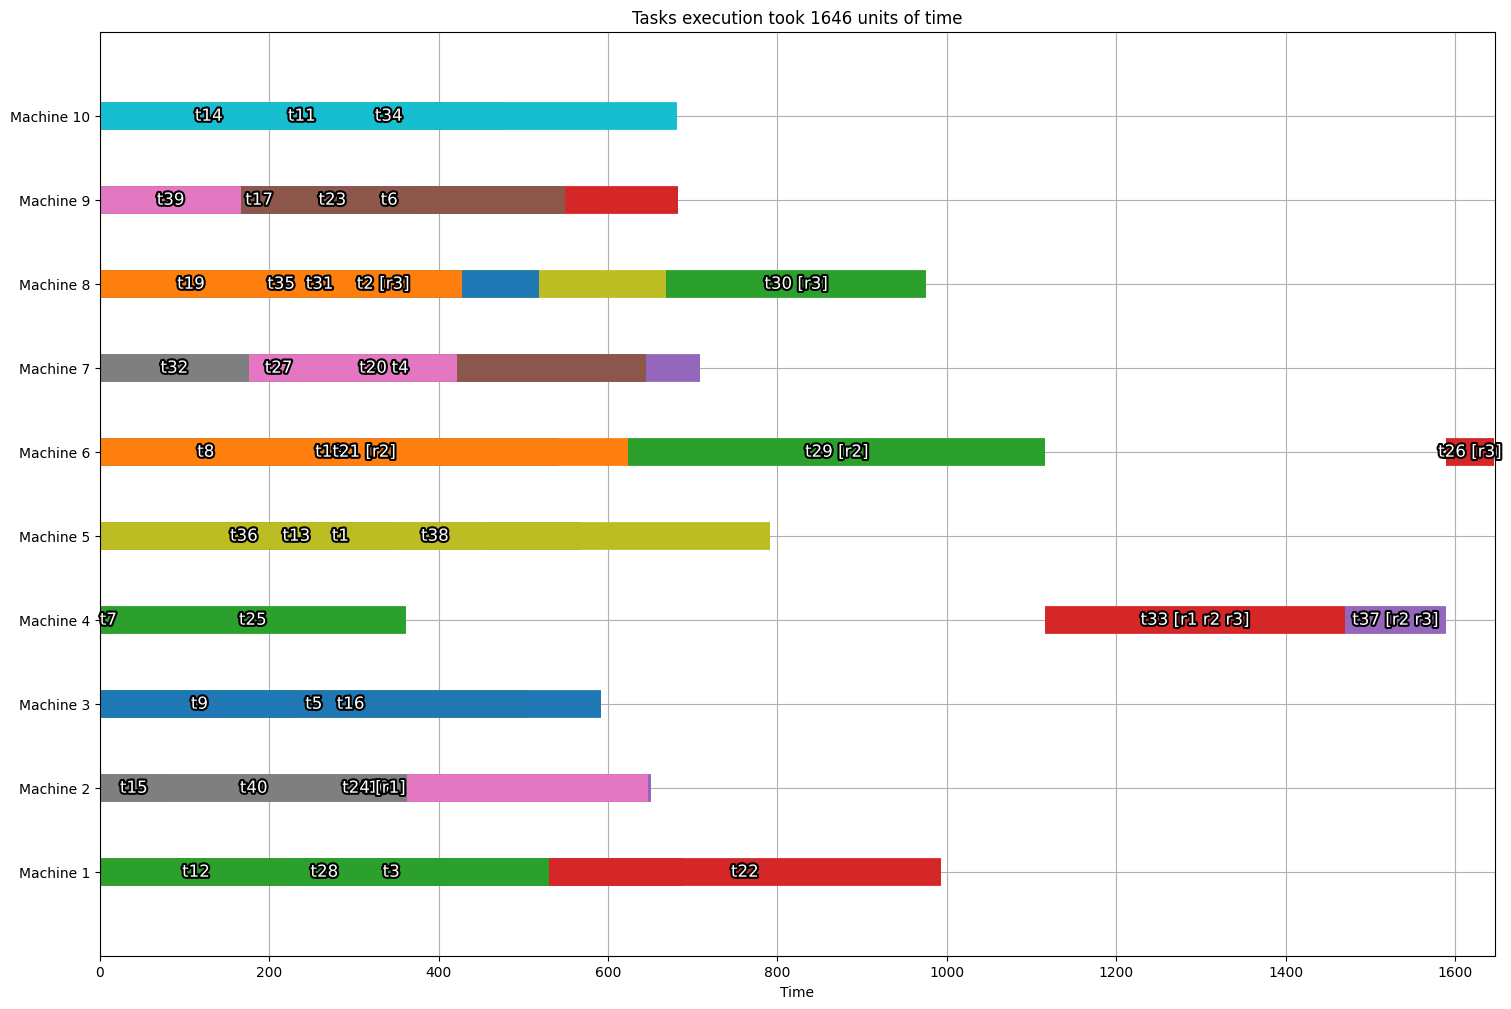

In [55]:
if result in (SAT, OPTIMUM): #drawing the result
    activities = []
    global machines_usages
    for machine in machines_usages:
        machine_activities = []
        for activity, start_time in sorted(machine.items(), key=lambda item: item[1]):
            name, _, _ = activity.split(', ')
            name = name.split('=')[0]  # Extracting the activity name
            start_time = int(start_time)
            duration = int(activity.split(', ')[-1].split('=')[-1])
            machine_activities.append({'name': name, 'start_time': start_time, 'duration': duration})
        activities.append(machine_activities)
    draw_schedule(activities, value(score), max(18, int(value(score)/100)), max(12, int(nMachines/2)))